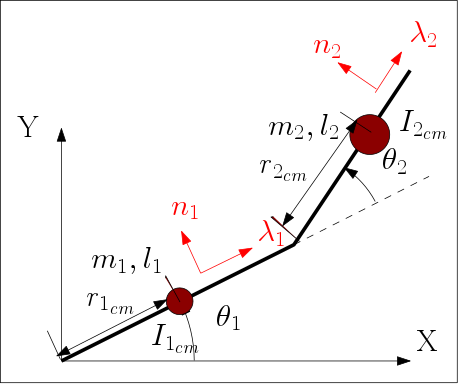

In [1]:
from IPython.display import Image 
from IPython.display import IFrame
IFrame("https://github.com/shyamashi/model_predictive_control/blob/master/src/2R%20manipulator%20theory/2R_manipulator_EOM.pdf", width=900, height=800)
Image(filename='/home/ar0058/Dropbox/Teaching Assistanship/Dynamics/Homework 3/2R_manip_2.png') 

The dynamic equations can be written as


In [2]:
from IPython.display import Latex
Latex(r"""\begin{align*}
M(q)\ddot{q} + C(q, \dot{q}) + G(q) = \tau
\end{align*}""")

Latex(r"""\begin{multline}
	(I_1 + I_2 + m_2l_1^2 + m_1 r_{1_{cm}}^2 + m_2 r_{2_{cm}}^2 + 2 m_2 l_1 r_{2_{cm}} \cos\theta_2)\ddot{\theta}_1 + (I_2 + m_2 r_{2_{cm}}^2 + m_2 l_1 r_{2_{cm}} \cos\theta_2) \ddot{\theta}_2 - \\m_2 l_1 r_{2_{cm}} \sin\theta_2(2\dot{\theta}_1 + \dot{\theta}_2) \dot{\theta}_2 + m_2 g (l_1 \cos\theta_1 + r_{2_{cm}} \cos(\theta_1 + \theta_2)) +m_1 g r_{1_{cm}} \cos\theta_1 = \tau_1
	\\
	(I_2 + m_2 r_{2_{cm}}^2 + m_2l_1r_{2_{cm}} \cos\theta_2) \ddot{\theta}_1 + (I_2 + m_2 r_{2_{cm}}^2) \ddot{\theta}_2 + m_2 l_1 r_{2_{cm}} \sin\theta_2 \dot{\theta}_1^2 + m_2 r_{2_{cm}} g \cos(\theta_1 + \theta_2) = \tau_2
\end{multline}""")


<IPython.core.display.Latex object>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sympy import *
from sympy.physics.mechanics import *
from sympy.tensor.array import Array

In [4]:
q1, q2 = dynamicsymbols('q1 q2')  # joint variables (same as theta_1, theta_2)
r1, r2 = symbols('r1 r2')  # COM vector (same as r1_cm, r2_cm)
q1d, q2d = dynamicsymbols('q1 q2', 1)  # angular velocities
tau_1, tau_2, I1_zz, I2_zz, m1, m2 = symbols('tau_1 tau_2 I1_zz, I2_zz, m1, m2')  # Torques, Inertia about com Z axis, masses
l1, l2, g = symbols('l_1 l_2 g', positive=True)  # link lengths and gravity magnitude

t = np.linspace(0, 1, 50)

l =[l1, l2]
m = [m1, m2]
q = [q1, q2]
qd = [q1d, q2d]

grav = transpose(Matrix([[0, g, 0]]))

# Inertia tensor wrt centre of mass of each link
I1 = zeros(3, 3)
I1[2, 2] = I1_zz

I2 = zeros(3, 3)
I2[2, 2] = I2_zz

I = [I1, I2]

# COM vectors 
r11 = zeros(3, 1)
r11[0] = r1

r22 = zeros(3, 1)
r22[0] = r2

r = zeros(3, 2)
r[:, 0] = r11
r[:, 1] = r22

# DH parameters of the 2R manipulator
a = Array([0.0, l1, l2])
d = Array([0.0, 0.0, 0.0])
alpha = Array([0.0, 0.0, 0.0])




In [5]:
# Symbolic forward kinematics from DH parameters
def fwd_kin_symbolic(q):
    q_i = Symbol("q_i")
    alpha_i = Symbol("alpha_i")
    a_i = Symbol("a_i")
    d_i = Symbol("d_i")
    T = Matrix([[cos(q_i), -sin(q_i), 0, a_i],
                [sin(q_i) * cos(alpha_i), cos(q_i) * cos(alpha_i), -sin(alpha_i), -sin(alpha_i) * d_i],
                [sin(q_i) * sin(alpha_i), cos(q_i) * sin(alpha_i), cos(alpha_i), cos(alpha_i) * d_i],
                [0, 0, 0, 1]])
    T_joint, T_i_i1 = [], []  #  T_joint and T_i_i1 are respectively the 4x4 transformation matrix relating i_th frame  wrt 0 and i+1 frame wrt i
    t = eye(4)
    for i in range(len(q)):
        temp = T.subs(alpha_i, alpha[i]).subs(a_i, a[i]).subs(d_i, d[i]).subs(q_i, q[i])
        t = t*temp
        T_joint.append(t)
        T_i_i1.append(temp)
    return T_joint, T_i_i1


The velocities of the joints are based on the following formulas

In [6]:
Latex(r"""\begin{align*}
^i\omega_i &=~ ^i _{i-1}[R]~^{i-1}\omega_{i-1} +~ \dot{\theta}_i (0~ 0~ 1)^T \\
^iV_i &=~ ^i _{i-1}[R]~^{i-1}V_{i-1} + ~^{i - 1}\omega_{i - 1} \times ~^{i - 1}O_i
\end{align*}""")

<IPython.core.display.Latex object>

The velocity of the centre of mass can be found as

In [7]:
Latex(r"""\begin{align*}
^iV_{Ci} &=~ ^{i}V_{i} + ~^i \omega_i \times ~^iP_{Ci}
\end{align*}""")

<IPython.core.display.Latex object>

In [8]:
# For detailed explanation of the formulas, please refer to https://nptel.ac.in/courses/112108093/6
def velocities(q):
    omega = Matrix.zeros(3, len(q)+1)
    joint_velocity = Matrix.zeros(3, len(q)+1)
    cm_vel = Matrix.zeros(3, len(q))
    _, t_i_i1 = fwd_kin_symbolic(q)  # T_i_i1 is the 4x4 transformation matrix of i+1 frame wrt to i
    for i in range(len(q)):
        R = t_i_i1[i][0:3, 0:3].transpose()
        omega[:, i+1] = R * omega[:, i] + Matrix([[0], [0], [qd[i]]])
        joint_velocity[:, i+1] = R * (joint_velocity[:, i] + omega[:, i].cross(t_i_i1[i][0:3, 3]))
    omega, joint_velocity = omega[:, 1:], joint_velocity[:, 1:]
    for i in range(len(q)):
        # cm_vel[:, i] = joint_velocity[:, i] + omega[:, i].cross(t_i_i1[i][0:3, 3]/2)
        cm_vel[:, i] = joint_velocity[:, i] + omega[:, i].cross(r[:, i])
    return omega, cm_vel, joint_velocity

In [9]:
def kinetic_energy(q):
    w, cm_vel, joint_velocity = velocities(q)
    K = 0
    for i in range(len(q)):
        K += 0.5*m[i]*cm_vel[:, i].dot(cm_vel[:, i]) + 0.5*w[:, i].dot(I[i]*w[:, i])
    return K

def potential_energy(q):
    T_joint, _ = fwd_kin_symbolic(q)  # T_joint is the 4x4 transformation matrix relating i_th frame  wrt to 0
    P = 0
    for i in range(len(q)):
        r_0_cm = T_joint[i][0:3, 0:3]*r[:, i] + T_joint[i][0:3, 3]  # com vector wrt 0
        P += m[i]*grav.dot(r_0_cm)
    return P

In [10]:
def get_dyn_para(q, qd):
    K = kinetic_energy(q)
    P = potential_energy(q)
    L = K - P  # Lagrangian
    M = transpose(Matrix([[K]]).jacobian(qd)).jacobian(qd).applyfunc(trigsimp)  # Mass matrix
    C = transpose(Matrix([[K]]).jacobian(qd)).jacobian(q) * Matrix(qd) - transpose(Matrix([[K]]).jacobian(q))  # Coriolis vector
    C = C.applyfunc(trigsimp)
    G = transpose(Matrix([[P]]).jacobian(q)).applyfunc(trigsimp)  # Gravity vector
    # LM = LagrangesMethod(L, q)
    # LM.form_lagranges_equations()
    # print LM.mass_matrix.applyfunc(trigsimp)
    # Matrix([P]).applyfunc(trigsimp)
    return M, C, G

In [11]:
# reference trajectory
def ref_trajectory(self, i):  # y = 3*sin(2*pi*omega*t)
    omega = 0.5
    # y_ref = 3 * np.sin(2*np.pi*omega*t[i])
    y_ref = np.array([[0], [2], [0]])
    return y_ref
    # return sp.Matrix(([[self.t[i]], [y], [0]]))

In [12]:
T_eff = eye(4)
T_eff[0, 3] = l2

def fwd_kin_numeric(lp, qp):  # provide the values of link lengths and joint angles to get the end-eff pose
    T_joint, _ = fwd_kin_symbolic(q)
    T_0_eff = T_joint[-1] * T_eff
    for i in range(len(q)):
        T_0_eff = T_0_eff.subs(q[i], qp[i]).subs(l[i], lp[i])
    Rot_0_eff = T_0_eff[0:3, 0:3]
    pos_0_eff = T_0_eff[0:3, 3]
    return pos_0_eff, Rot_0_eff

def dyn_para_numeric(lp, qp, qdp):
    M, C, G = get_dyn_para(q, qd)
    for i in range(len(qp)):
        M = M.subs(q[i], qp[i]).subs(l[i], lp[i])
        C = C.subs(q[i], qp[i]).subs(l[i], lp[i]).subs(qd[i], qdp[i])
        G = G.subs(q[i], qp[i]).subs(l[i], lp[i])
    return M, C, G
        


In [13]:
# output
pos, rot = fwd_kin_numeric(lp, qp)

NameError: name 'lp' is not defined